In [21]:
import pandas as pd
import nltk
import numpy as np
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt   
import matplotlib.style
plt.style.use('classic')
from nltk import word_tokenize
from nltk import download
from nltk.corpus import stopwords
#importing seaborn for statistical plots
import seaborn as sns
import sklearn.metrics as metrics
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy


In [12]:
csm = pd.read_excel('csm.xlsx', sheetname='Actual')
csm.columns

C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


Index(['number', 'short_description', 'Analysis_Category'], dtype='object')

In [13]:
csm.head()
csm.shape

(4692, 3)

In [14]:
csm['Analysis_Category'].describe()

count                        4692
unique                        106
top       EY Monitoring Incidents
freq                         1556
Name: Analysis_Category, dtype: object

In [15]:
csm = pd.DataFrame(csm)

In [16]:
#define X and y
X = csm.short_description
y = csm.Analysis_Category

In [23]:
from nltk.corpus import wordnet
default_stopwords = set(nltk.corpus.stopwords.words('english'))
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    #print(tag)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    output = tag_dict.get(tag[0]) 
    if output:
        return output
    else:
        return 'v'

In [24]:
def pre_process( SD ):
    lm = WordNetLemmatizer()
    letters_only = re.sub("[^a-zA-Z]", " ", SD)
    #print(letters_only)
    sentences = nltk.word_tokenize(str(letters_only))
    #print(sentences)
    sentences = [word.lower() for word in sentences]
    no_stops = [word for word in sentences if not word in default_stopwords]
    #print(no_stops)
    lem_word = [lm.lemmatize(word,get_wordnet_pos(word)) for word in no_stops]
    #print(lem_word)
    #tags = st.tag(lem_word)
    #tagged_words = [word for word,tag in tags if tag!='PERSON' and tag!='LOCATION']
    tokens = [word.lower() for word in lem_word if len(word) > 2]
    #print(tokens)
    return( " ".join(tokens))

In [26]:
print("Number of Rows Parsed......................\n")
corpus = []
num_SD = len(X)
%time
for i in range( 0, num_SD ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1500 == 0 ):
        print("Cleaned Short Descriptions %d of %d" % ( i+1, num_SD ))
    corpus.append( pre_process(str(X.iloc[i])))

Number of Rows Parsed......................

Wall time: 0 ns
Cleaned Short Descriptions 1500 of 4692
Cleaned Short Descriptions 3000 of 4692
Cleaned Short Descriptions 4500 of 4692


In [28]:
#split into training and testing
from sklearn.cross_validation import train_test_split
X_train_txt, X_test_txt, y_train, y_test = train_test_split(X,y,random_state=1)

In [29]:
print(X_train_txt.shape)
print(X_test_txt.shape)
print(y_train.shape)
print(y_test.shape)

(3519,)
(1173,)
(3519,)
(1173,)


In [37]:
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3),min_df=10,max_features=5000,lowercase=True)
X_dtm_train = tfidf_vec.fit_transform((X_train_txt))
X_dtm_train.shape

(3519, 796)

In [38]:
X_dtm_test = tfidf_vec.transform(X_test_txt)
X_dtm_test.shape

(1173, 796)

In [39]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [40]:
svcclassifier = SVC(random_state=0,kernel='linear')
svcclassifier.fit(X_dtm_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=0, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
svcclassifier.score(X_dtm_train,y_train)

0.8402955385052572

In [43]:
y_pred_svm = svcclassifier.predict(X_dtm_test)

In [44]:
logreg = LogisticRegression(C=1e9)
logreg.fit(X_dtm_train,y_train)
y_pred_class_logreg = logreg.predict(X_dtm_test)

In [45]:
nb = MultinomialNB()
nb.fit(X_dtm_train,y_train)
y_pred_class_nb = nb.predict(X_dtm_test)

In [46]:
import matplotlib.pyplot as plt   
import matplotlib.style
plt.style.use('classic')

#importing seaborn for statistical plots
import seaborn as sns

In [47]:
error = []
# Calculating error for K values for 5, 13 and 21
for i in range(1,49):  
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_dtm_train, y_train)
    pred_i = knn.predict(X_dtm_test)
    error.append(np.mean(pred_i != y_test))

Text(0,0.5,'Mean Error')

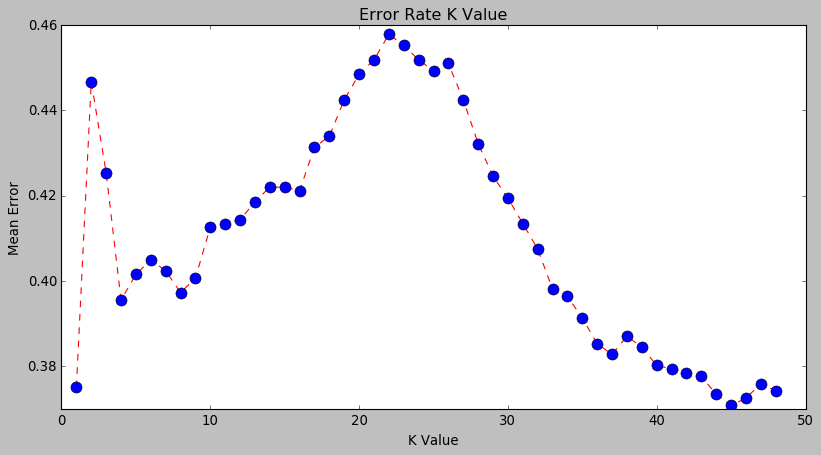

In [48]:
plt.figure(figsize=(12, 6))  
plt.plot(range(1,49), error, color='red', linestyle='dashed', marker='o',  
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')  
plt.xlabel('K Value')  
plt.ylabel('Mean Error') 

In [50]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion='entropy',random_state=0,max_depth=100,min_samples_leaf=15)
classifier.fit(X_dtm_train,y_train)
y_pred_tree = classifier.predict(X_dtm_test)

In [51]:
from sklearn.ensemble import RandomForestClassifier
rand_classifer = RandomForestClassifier(n_estimators=100,criterion='gini',random_state=0)
rand_classifer.fit(X_dtm_train,y_train)
y_pred_randforest = rand_classifer.predict(X_dtm_test)

In [55]:
print("SVM ACCURACY:",metrics.accuracy_score(y_test,y_pred_svm))
#print('SVM CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_svm))
#print("===> **SVM F1 SCORE",metrics.f1_score(y_test, y_pred_svm,average=None))
#print("===> **SVM Recall SCORE",metrics.recall_score(y_test, y_pred_svm,average=None))
#print("===> **SVM Precision SCORE",metrics.precision_score(y_test, y_pred_svm,average=None))
#print("===> **SVM ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_svm,average=None))
print("##################################################################################################")
print("LogisticReg ACCURACY:",metrics.accuracy_score(y_test,y_pred_class_logreg,))
#print('LogisticReg CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_class_logreg))
#print("===> **LogisticReg F1 SCORE",metrics.f1_score(y_test, y_pred_class_logreg,average=None))
#print("===> **LogisticReg Recall SCORE",metrics.recall_score(y_test, y_pred_class_logreg,average=None))
#print("===> **LogisticReg Precision SCORE",metrics.precision_score(y_test, y_pred_class_logreg,average=None))
#print("===> **LogisticReg ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_class_logreg,average=None))
print("##################################################################################################")
print("NaiveBayes ACCURACY:",metrics.accuracy_score(y_test,y_pred_class_nb))
#print('NaiveBayes CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_class_nb))
#print("===> **NaiveBayes F1 SCORE",metrics.f1_score(y_test, y_pred_class_nb,average=None))
#print("===> **NaiveBayes Recall SCORE",metrics.recall_score(y_test, y_pred_class_nb,average=None))
#print("===> **NaiveBayes Precision SCORE",metrics.precision_score(y_test, y_pred_class_nb,average=None))
#print("===> **NaiveBayes ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_class_nb,average=None))
print("##################################################################################################")
#print("KNN ACCURACY:",metrics.accuracy_score(y_test,y_pred_class_knn))
#print('KNN CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_class_knn))
#print("===> **KNN F1 SCORE",metrics.f1_score(y_test, y_pred_class_knn,average=None))
#print("===> **KNN Recall SCORE",metrics.recall_score(y_test, y_pred_class_knn,average=None))
#print("===> **KNN Precision SCORE",metrics.precision_score(y_test, y_pred_class_knn,average=None))
#print("===> **KNN ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_class_knn,average=None))
#print("##################################################################################################")
print("Dtree ACCURACY:",metrics.accuracy_score(y_test,y_pred_tree))
#print('Dtree CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_tree))
#print("===> **Dtree F1 SCORE",metrics.f1_score(y_test, y_pred_tree,average=None))
#print("===> **Dtree Recall SCORE",metrics.recall_score(y_test, y_pred_tree,average=None))
#print("===> **Dtree Precision SCORE",metrics.precision_score(y_test, y_pred_tree,average=None))
#print("===> **Dtree ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_tree,average=None))
print("##################################################################################################")
print("RandForest ACCURACY:",metrics.accuracy_score(y_test,y_pred_randforest))
#print('RandForest CLASSIFIER CONFUSTION MATRIX:',pd.crosstab(y_test,y_pred_randforest))
#print("===> **RandForest F1 SCORE",metrics.f1_score(y_test, y_pred_randforest,average=None))
#print("===> **RandForest Recall SCORE",metrics.recall_score(y_test, y_pred_randforest,average=None))
#print("===> **RandForest Precision SCORE",metrics.precision_score(y_test, y_pred_randforest,average=None))
#print("===> **RandForest ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_randforest,average=None))

SVM ACCURACY: 0.7621483375959079
##################################################################################################
LogisticReg ACCURACY: 0.6683716965046889
##################################################################################################
NaiveBayes ACCURACY: 0.618925831202046
##################################################################################################
Dtree ACCURACY: 0.5933503836317136
##################################################################################################
RandForest ACCURACY: 0.7604433077578857


In [56]:
from sklearn.ensemble import GradientBoostingClassifier
gbcl = GradientBoostingClassifier(n_estimators = 50, learning_rate = 0.1, max_depth=10)
gbcl = gbcl.fit(X_dtm_train, y_train)

In [57]:
y_pred_gbcl = gbcl.predict(X_dtm_test)

In [60]:
print("GBC: ACCURACY:",metrics.accuracy_score(y_test,y_pred_gbcl))
#print('GBC CLASSIFIER CONFUSTION MATRIX:%\n',pd.crosstab(y_test,y_pred_gbcl))
print("===> **GBC F1 SCORE",metrics.f1_score(y_test, y_pred_gbcl,average=None))
#print("===> **GBC Recall SCORE",metrics.recall_score(y_test, y_pred_gbcl,average=None))
#print("===> **GBC Precision SCORE",metrics.precision_score(y_test, y_pred_gbcl,average=None))
#print("===> **GBC ROC_AUC SCORE",metrics.roc_auc_score(y_test, y_pred_gbcl,average=None))

GBC: ACCURACY: 0.7127024722932651


C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


===> **GBC F1 SCORE [0.17391304 0.7388535  0.         0.         0.28571429 0.
 0.5        0.         0.         0.         0.54545455 0.57142857
 0.         0.         0.         0.         0.5        0.
 0.         0.         0.59259259 0.         0.28571429 0.25
 0.86419753 0.         0.5        0.18181818 0.         0.
 0.         0.         0.         0.72727273 0.995      0.
 0.         1.         0.6744186  0.         0.66666667 0.
 0.         0.54545455 0.66666667 0.         0.         0.59459459
 0.         0.4        0.         0.66666667 0.1        0.69158879
 0.47678019 0.         0.         0.         0.94117647 0.17391304
 0.9        0.         0.6440678  0.         0.         0.
 0.         0.         0.66666667 0.69565217 0.77777778 0.
 0.         0.73015873 0.66666667 0.73684211 0.         0.
 0.75       0.5        0.75       0.         0.88888889 0.
 0.         0.28571429 0.         0.66666667]


In [68]:
models = [
    RandomForestClassifier(n_estimators=200, random_state=0),
    LinearSVC(),
]
CV = 10
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
re = []
pre = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, X_dtm_train, y_train, scoring='accuracy', cv=CV)
    #recalls = cross_val_score(model, X_dtm_train, y_train, scoring='recall', cv=CV,)
    #precisions = cross_val_score(model, X_dtm_train, y_train, scoring='precision', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
    #for rec, recall in enumerate(recalls):
     #   re.append((model_name,rec,recall))
    #for prec, preci in enumerate(precisions):
     #   pre.append((model_name,prec,preci))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
C:\Users\madhan.s\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


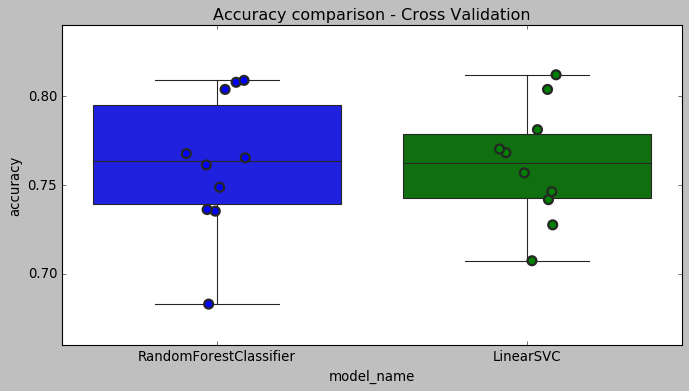

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(x='model_name', y='accuracy', data=cv_df).set_title("Accuracy comparison - Cross Validation")
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()